# Set up a simple thermal model
This thermal model has three stages, representing a cryostat with a fixed outer shell temperature near room temp, and a fixed inner temperature, representing a fixed thermal bath.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from cryotherm import DATA_PATH                      # packaged resource
from cryotherm.material_db import MaterialDatabase
from cryotherm.stage import Stage
from cryotherm.conduction import Conduction
from cryotherm.radiation import Radiation
from cryotherm.solver import ThermalModel

# ---------------------------------------------------------------------
# Material DB
# ---------------------------------------------------------------------
db = MaterialDatabase(DATA_PATH)



# ---------------------------------------------------------------------
#  Stages
# ---------------------------------------------------------------------
outer_shell_temp = 290  # K
middle_stage_temp = 100  # K
inner_stage_temp = 40  # K

outer = Stage("Outer Shell", outer_shell_temp, fixed=True)
middle = Stage("Middle Stage", middle_stage_temp, fixed=False)
inner = Stage("Inner Stage", inner_stage_temp, fixed=True)

# ---------------------------------------------------------------------
#  Conduction
# ---------------------------------------------------------------------

# Middle Stage Support
outer_dia = 0.5 # outer diameter in metres
inner_dia = 0.496  # inner diameter in metres
length = 0.5  # length in metres
material = "G10warp"  # material of the support cylinder
# set up the support using the geometric methods
middle_stage_mech_support = Conduction(outer, middle, type = "tube", outer_dia=outer_dia, inner_dia=inner_dia,
                              length=length, number=1,
                              material=material, mat_db=db, method = "legacy", name = "Middle Stage Support")


## Diagnotics/Debugging
print("Middle Stage Support Diagnostics:")
area = np.pi * (outer_dia**2 - inner_dia**2) / 4  # cross-sectional area
print(f"\tMaterial: {material}")
print(f"\tOuter diameter: {outer_dia} m")
print(f"\tInner diameter: {inner_dia} m")
print(f"\tLength: {length} m")
print(f"\tCross-sectional area: {area:.2e} m²")
print(f"\tA/L: {area/length:.3e} m")
print(f"\tConInt: {db.get_integral(material, T1 = middle_stage_temp, T2 = outer_shell_temp, method='legacy'):.3f} W/K")
print(f"\tPower: {middle_stage_mech_support.heat_flow(outer_shell_temp, middle_stage_temp):.2e} W")



# Inner Stage Support
outer_dia = 0.005 # outer diameter in metres
inner_dia = 0.004  # inner diameter in metres
length = 0.1  # length in metres
material = "G10warp"  # material of the support cylinder
number = 3  # number of support rods
inner_stage_mech_support = Conduction(middle, inner, type = "tube", outer_dia=outer_dia, inner_dia=inner_dia,
                              length=length, number=number,
                              material=material, mat_db=db, method = "legacy", name = "Inner Stage Support")

## Diagnostics/Debugging
print("Inner Stage Support Diagnostics:")
area = np.pi * (outer_dia**2 - inner_dia**2) / 4  # cross-sectional area
print(f"\tMaterial: {material}")
print(f"\tOuter diameter: {outer_dia} m")
print(f"\tInner diameter: {inner_dia} m")
print(f"\tLength: {length} m")
print(f"\tCross-sectional area: {area:.3e} m²")
print(f"\tA/L: {area/length:.2e} m")
print(f"\tConInt: {db.get_integral(material, T1 = middle_stage_temp, T2 = inner_stage_temp, method='legacy'):.3f} W/K")
print(f"\tPower: {inner_stage_mech_support.heat_flow(middle_stage_temp, inner_stage_temp):.2e} W")


# Cabling: Outer -> Middle
outer_dia = 0.0001  # outer diameter in metres
length = 0.1  # length in metres
material = "SS304L"  # material of the support cylinder
number = 10  # number of cables
cabling_outer_to_middle = Conduction(outer, middle, type = "cylinder", outer_dia=outer_dia, length=length, number=number,
                     material=material, mat_db=db, method = "legacy", name = "Cabling")

# Diagnostics/Debugging
area = np.pi * (outer_dia**2) / 4  # cross-sectional area
print("Cabling: Outer -> Middle")
print(f"\tMaterial: {material}")
print(f"\tOuter diameter: {outer_dia} m")
print(f"\tLength: {length} m")
print(f"\tCross-sectional area: {area:.3e} m²")
print(f"\tA/L: {area/length:.2e} m")
print(f"\tConInt: {db.get_integral(material, T1 = outer_shell_temp, T2 = middle_stage_temp, method='legacy'):.3f} W/K")
print(f"\tPower: {cabling_outer_to_middle.heat_flow(outer_shell_temp, middle_stage_temp):.2e} W")

# Cabling: Middle -> Inner
outer_dia = 0.0001  # outer diameter in metres
length = 0.1  # length in metres
material = "SS304L"  # material of the support cylinder
number = 10  # number of cables
cabling_middle_to_inner = Conduction(middle, inner, type = "cylinder", outer_dia=outer_dia, length=length, number=number,
                     material=material, mat_db=db, method = "legacy", name = "Cabling")

# Diagnostics/Debugging
area = np.pi * (outer_dia**2) / 4  # cross-sectional area
print("Cabling: Middle -> Inner")
print(f"\tMaterial: {material}")
print(f"\tOuter diameter: {outer_dia} m")
print(f"\tLength: {length} m")
print(f"\tCross-sectional area: {area:.3e} m²")
print(f"\tA/L: {area/length:.2e} m")
print(f"\tConInt: {db.get_integral(material, T1 = middle_stage_temp, T2 = inner_stage_temp, method='legacy'):.3f} W/K")

print(f"\tPower: {cabling_middle_to_inner.heat_flow(middle_stage_temp, inner_stage_temp):.2e} W")

# ---------------------------------------------------------------------
# Radiation
# ---------------------------------------------------------------------
# Radiation: Outer -> Middle
diameter = 0.25 # outer diameter in metres
height = 0.25 # height in metres
area_plate = diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * diameter * height  # area of the cylindrical wall

total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
# Emissivity values for the outer and inner surfaces
emissivity_outer = 0.03
emissivity_inner = 0.03

radiation_outer_to_middle = Radiation(outer, middle, type = "cylinder", diameter = diameter, height = height, emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name= None)
print("Radiation: Outer -> Middle")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_outer_to_middle.heat_flow(outer_shell_temp, middle_stage_temp):.2e} W")

# Radiation: Middle -> Inner
diameter = 0.15 # outer diameter in metres
height = 0.15 # height in metres
area_plate = diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * diameter * height  # area of the cylindrical wall
total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
emissivity_outer = 0.03
emissivity_inner = 0.03

radiation_middle_to_inner = Radiation(middle, inner, type = "cylinder", diameter = diameter, height = height, emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name = None)
print("Radiation: Middle -> Inner")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_middle_to_inner.heat_flow(middle_stage_temp, inner_stage_temp):.2e} W")



# ---------------------------------------------------------------------
#  Solve
# ---------------------------------------------------------------------
model = ThermalModel(
    stages=[outer, middle, inner],
    conductors=[middle_stage_mech_support, inner_stage_mech_support, cabling_outer_to_middle, cabling_middle_to_inner],
    radiators=[radiation_outer_to_middle, radiation_middle_to_inner],
)

model.solve()                     # raises if the optimizer fails

for s in model.stages:
    print(f"{s.name:15s}:  {s.temperature:6.2f} K   netQ={s.net_heat_flow:+8.4f} W")


Middle Stage Support Diagnostics:
	Material: G10warp
	Outer diameter: 0.5 m
	Inner diameter: 0.496 m
	Length: 0.5 m
	Cross-sectional area: 3.13e-03 m²
	A/L: 6.258e-03 m
	ConInt: 125.375 W/K
	Power: 7.85e-01 W
Inner Stage Support Diagnostics:
	Material: G10warp
	Outer diameter: 0.005 m
	Inner diameter: 0.004 m
	Length: 0.1 m
	Cross-sectional area: 7.069e-06 m²
	A/L: 7.07e-05 m
	ConInt: 22.056 W/K
	Power: 4.68e-03 W
Cabling: Outer -> Middle
	Material: SS304L
	Outer diameter: 0.0001 m
	Length: 0.1 m
	Cross-sectional area: 7.854e-09 m²
	A/L: 7.85e-08 m
	ConInt: 2356.412 W/K
	Power: 1.85e-03 W
Cabling: Middle -> Inner
	Material: SS304L
	Outer diameter: 0.0001 m
	Length: 0.1 m
	Cross-sectional area: 7.854e-09 m²
	A/L: 7.85e-08 m
	ConInt: 438.455 W/K
	Power: 3.44e-04 W
Radiation: Outer -> Middle
	Plate area: 0.049 m²
	Wall area: 0.196 m²
	Total surface area: 0.295 m²
	Power: 1.18e+00 W
Radiation: Middle -> Inner
	Plate area: 0.018 m²
	Wall area: 0.071 m²
	Total surface area: 0.106 m²
	Power: 

# Visualize the Model


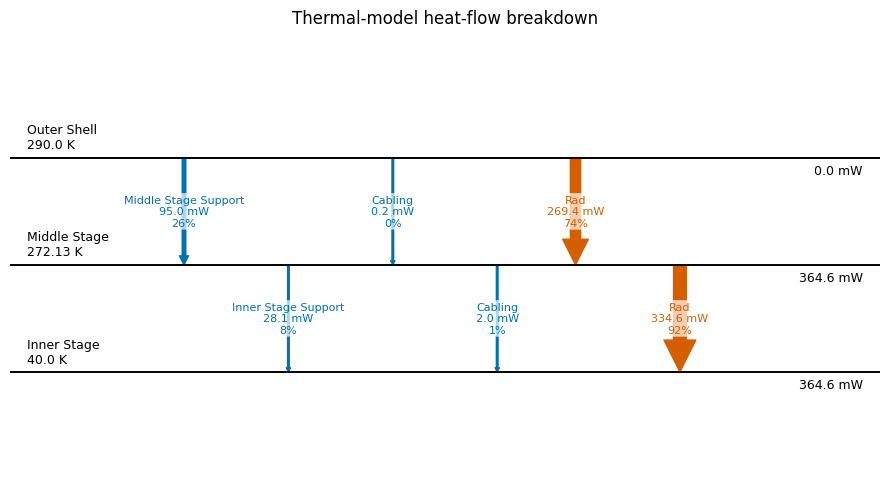

In [2]:
from cryotherm.visualize import visualize_model   # or paste the code block once
model.solve()                                     # your model must be solved
visualize_model(model, scale = 50)

